# Classification and Regression

Problema propusa este prezicerea label-urilor **Breed Name** si **Longevity(yrs)** comparand diferite modele cu diversi hiper-parametrii. Setul de date contine informatii despre caini precum: Weight(g),  Height(cm),  Energy  level,Attention  Needs,Owner  Name,  Coat  Length,  Sex.

Modelele ce trebuie folosite si comparate sunt: *Linear Regression (Ridge, Lasso)*, *Logistic Regression*, *Random Forests* si *KNN*.

In [3]:
from google.colab import files

uploaded = files.upload()

Saving Ciolacu_C_Florentina_Neluța_train.csv to Ciolacu_C_Florentina_Neluța_train.csv


## Citirea datelor

In [0]:
import numpy as np
import pandas as pd

dataset = pd.read_csv("Ciolacu_C_Florentina_Neluța_train.csv")

## Renuntarea la datele nule

Am cautat valorile nule, apoi am renuntat la ele, dupa care am resetat indecsii.

In [32]:
print(dataset.isnull().sum())

Breed Name           0
Weight(g)            0
Height(cm)         184
Longevity(yrs)       0
Energy level         0
Attention Needs      0
Coat Lenght          0
Sex                  0
Owner Name           0
dtype: int64


In [0]:
modified_dataset = dataset.dropna()
modified_dataset = modified_dataset.reset_index(drop=True)

### Renuntarea la coloana Owner Name

Aceasta nu era necesara pentru rezolvarea problemei.

In [0]:
modified_dataset = modified_dataset.drop('Owner Name', axis=1)

## Encodarea Categorical Data

Cea mai buna abordare pentru datele de tip "categorical" a fost encodarea sub forma one hot.

Coloanele de acest tip au fost: Energy Level, Attention Needs, Coat Lenght, Sex.

In [0]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = ["Energy level", "Attention Needs", "Coat Lenght", "Sex"]
for column in categorical_columns:
    le = LabelEncoder()
    columns = set(dataset[column].tolist())
    columns = {key: value for key, value in zip(range(len(columns)), columns)}
    modified_dataset[column + "_encoded"] = le.fit_transform(modified_dataset[column])
    modified_dataset = modified_dataset.drop(column, axis=1) # drop the old collumns

### Vizualizarea distributiei datelor

Am incercat aplicarea functiei log pe coloana Weight(g), dar nu am obtinut rezultate cu mult diferite intr-un sens bun.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89f12ca0f0>,
      dtype=object)

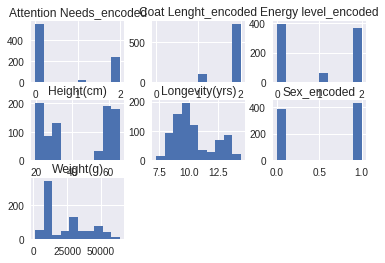

In [37]:
modified_dataset.hist()

In [0]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ["Energy level", "Attention Needs", "Coat Lenght", "Sex"]
for column in categorical_columns:
    ohe = OneHotEncoder()
    columns = set(dataset[column].tolist())
    columns = {key: value for key, value in zip(range(len(columns)), columns)}
    aux = ohe.fit_transform(modified_dataset[column + "_encoded"].values.reshape(-1, 1)).toarray()
    aux = pd.DataFrame(aux, columns=[column + "_" + columns.get(i) for i in range(aux.shape[1])])
    modified_dataset = pd.concat([modified_dataset, aux], axis=1)
    modified_dataset = modified_dataset.drop(column + "_encoded", axis=1)

## Normalizarea coloanelor Weight(g) si Height(cm)

In [0]:
modified_dataset["Weight(g)"] = (modified_dataset["Weight(g)"] - modified_dataset["Weight(g)"].min()) / (modified_dataset["Weight(g)"].max() - modified_dataset["Weight(g)"].min())
modified_dataset["Height(cm)"] = (modified_dataset["Height(cm)"] - modified_dataset["Height(cm)"].min()) / (modified_dataset["Height(cm)"].max() - modified_dataset["Height(cm)"].min())

# Task 1 - Classification

Pentru clasificare, trebuie sa renuntam la coloana de Longevity(yrs)

In [0]:
modified_dataset = modified_dataset.drop('Longevity(yrs)', axis=1)

## Encodarea coloanei de Breed Name

Deoarece variantele de Breed Name au fost considerate un numar limitat, am hotarat sa vad aceasta coloana ca niste numere asociate fiecarui Breed Name

In [0]:
breed_list = set(modified_dataset['Breed Name'].tolist())
breed_encoding = {}
for breed_name, index in zip(breed_list, range(len(breed_list))):
    breed_encoding[breed_name] = index
modified_dataset = modified_dataset
modified_dataset['Breed Name'] = modified_dataset['Breed Name'].map(lambda el: breed_encoding.get(el))

## Vizualizarea datelor

Plotarea in functie de Weight(g) si Height(cm)

In [0]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.scatter(modified_dataset["Weight(g)"], modified_dataset["Height(cm)"], c = modified_dataset["Breed Name"].values.reshape(-1), s = 50, cmap = "gnuplot", edgecolor = "black", linewidth=0.5)

## Impartirea setului de date in features si labels, apoi in train si test

In [0]:
from sklearn.model_selection import train_test_split

X = modified_dataset.drop('Breed Name', axis=1)
y = modified_dataset["Breed Name"]

x_train, x_test, y_train, y_test = train_test_split(X, y)

## Functia plot_decision_boundary

Functia de plotare a separarii punctelor/claselor in functie de hiperplane.

Alegerea featuririlor majoritare

In [0]:
print("Energy Level")
print(x_test["Energy level_low"].mode()[0])
print(x_test["Energy level_med"].mode()[0])
print(x_test["Energy level_high"].mode()[0])
print("Attention Needs")
print(x_test["Attention Needs_low"].mode()[0])
print(x_test["Attention Needs_med"].mode()[0])
print(x_test["Attention Needs_high"].mode()[0])
print("Coat Lenght")
print(x_test["Coat Lenght_short"].mode()[0])
print(x_test["Coat Lenght_med"].mode()[0])
print(x_test["Coat Lenght_long"].mode()[0])
print("Sex")
print(x_test["Sex_male"].mode()[0])
print(x_test["Sex_female"].mode()[0])

In [0]:
def plot_decision_boundary(model, X, y, class_no):
    #utilizarea feature-urilor majoritare
    features_maj = np.array([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1])
    X = np.array(X)
    y = np.array(y)
    xx, yy = np.mgrid[X[:,0].min():X[:,0].max():.01, X[:,1].min():X[:,1].max():.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    features_maj = np.tile(features_maj[np.newaxis,:], (grid.shape[0],1))
    grid = np.concatenate((grid, features_maj), axis=1) # concatenate them
    probs = model.predict_proba(grid)[:, class_no].reshape(xx.shape)
    f, ax = plt.subplots(figsize=(10, 10))
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu")
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = {})$".format(class_no))

    ax.scatter(X[:,0], X[:, 1], c=y, s=50,
             cmap="gnuplot",
             edgecolor="white", linewidth=1)

    ax.set(aspect="auto",
         xlabel="$X_1$", ylabel="$X_2$")

## Alegerea hiper-parametrilor folosind KFold cross validation

In [0]:
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_score, f1_score, accuracy_score


kf = KFold(n_splits=5)

for i, (Model, kwargs) in enumerate([(LogisticRegression, {}), (LogisticRegression, {"C": 1.0, "solver": 'newton-cg', "multi_class": 'multinomial'}), (LogisticRegression, {"C": 2.0, "solver": 'newton-cg', "multi_class": 'multinomial'}), (LogisticRegression, {"C": 1.0, "solver": 'sag', "multi_class": 'multinomial'}), (LogisticRegression, {"C": 2.0, "solver": 'sag', "multi_class": 'multinomial'}),
                                     (RandomForestClassifier, {}), (RandomForestClassifier, {"n_estimators": 50, "criterion": "entropy"}), (RandomForestClassifier, {"n_estimators": 50, "criterion": "gini"}), (RandomForestClassifier, {"n_estimators": 100, "criterion": "entropy"}), (RandomForestClassifier, {"n_estimators": 100, "criterion": "gini"}), 
                                     (KNeighborsClassifier, {}), (KNeighborsClassifier, {"n_neighbors": 2, "p": 1}), (KNeighborsClassifier, {"n_neighbors": 2, "p": 2}), (KNeighborsClassifier, {"n_neighbors": 3, "p": 1}), (KNeighborsClassifier, {"n_neighbors": 3, "p": 2}), (KNeighborsClassifier, {"n_neighbors": 4, "p": 1}), (KNeighborsClassifier, {"n_neighbors": 4, "p": 2}), (KNeighborsClassifier, {"n_neighbors": 5, "p": 1}), (KNeighborsClassifier, {"n_neighbors": 5, "p": 2}),]):
    accuracies = []
    precisions = []
    f1_scores = []
    print(Model.__name__, kwargs)
    for k, (train_index, test_index) in enumerate(kf.split(x_train)):
        xx_train = x_train.iloc[train_index]
        yy_train = y_train.iloc[train_index]

        xx_validation = x_train.iloc[test_index]
        yy_validation = y_train.iloc[test_index]

        model = Model(**kwargs)
        model.fit(xx_train, yy_train)
        
        accuracy = accuracy_score(yy_validation, model.predict(xx_validation))
        precision = precision_score(yy_validation, model.predict(xx_validation), average="weighted")
        f1 = f1_score(yy_validation, model.predict(xx_validation), average="weighted")
        accuracies.append(accuracy)
        precisions.append(precision)
        f1_scores.append(f1)
        print("split", k, "accuracy", accuracy, "precision", precision, "f1_score", f1)
    print("Average accuracy:", np.average(accuracies))
    print("Average precision:", np.average(precisions))
    print("Average f1 score:", np.average(f1_scores))
    print("\n\n")

In [0]:
best_models = [
    (LogisticRegression, {'C': 2.0, 'solver': 'newton-cg', 'multi_class': 'multinomial'}),
    (RandomForestClassifier, {'n_estimators': 50, 'criterion': 'entropy'}), 
    (KNeighborsClassifier, {'n_neighbors': 3, 'p': 1})
]

In [0]:
for i, (Model, kwargs) in enumerate(best_models):
    model = Model(**kwargs)
    model.fit(x_train, y_train)
  
    test_accuracy = accuracy_score(model.predict(x_test), y_test)
    test_precision = precision_score(y_test, model.predict(x_test), average="weighted")
    test_f1 = f1_score(y_test, model.predict(x_test), average="weighted")
    print(Model.__name__)
    print()
    print("accuracy", test_accuracy)
    print("precision", test_precision)
    print("f1_score", f1)
    print("\n")

## Calling the plot_decision_boundary function

In [0]:
Model, kwargs = best_models[0]
model = Model(**kwargs)
model.fit(x_train, y_train)
for cls in range(4):
    plot_decision_boundary(model, x_test, y_test, cls)

In [0]:
Model, kwargs = best_models[1]
model = Model(**kwargs)
model.fit(x_train, y_train)
for cls in range(4):
    plot_decision_boundary(model, x_test, y_test, cls)

In [0]:
Model, kwargs = best_models[2]
model = Model(**kwargs)
model.fit(x_train, y_train)
for cls in range(4):
    plot_decision_boundary(model, x_test, y_test, cls)

# Task 2 - Regression

Pentru regresie, trebuie sa renuntam la coloana Breed Name

In [0]:
modified_dataset = modified_dataset.drop('Breed Name', axis=1)

##Impartirea setului de date in features si labels, apoi in train si test

In [0]:
X = modified_dataset.drop('Longevity(yrs)', axis=1)
y = modified_dataset["Longevity(yrs)"]

x_train, x_test, y_train, y_test = train_test_split(X, y)

##Vizualizarea datelor

Dependenta coloanei Longevity(yrs) de coloanele Weight(g) si Height(cm)

[0, 150, -1, 2]

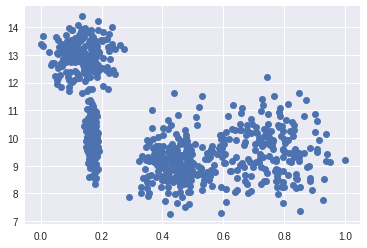

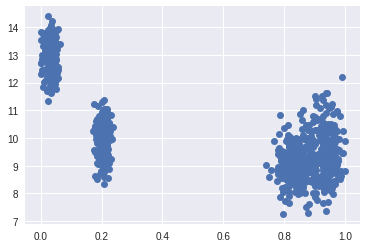

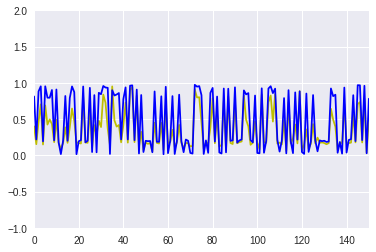

In [46]:
plt.figure()
plt.plot(X["Weight(g)"], y, "o")
plt.figure()
plt.plot(X["Height(cm)"], y, "o")
plt.figure()
plt.plot(X["Weight(g)"], 'y')
plt.plot(X["Height(cm)"], "b")
plt.axis([0, 150, -1, 2])

##Alegerea hiper-parametrilor folosind Grid Search Cross Validation

Am utilizat aceasta metoda pentru a descoperi care este combinatia care are cel mai bun scor.

In [0]:
from sklearn.model_selection import GridSearchCV

###Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
params = {}
reg = GridSearchCV(model, params, cv=5, return_train_score=True, scoring="neg_mean_squared_error")
reg.fit(X, y)
results = reg.cv_results_
for res in results:
    print(str(res) + ": " + str(results[res]))

###Ridge

In [0]:
from sklearn.linear_model import Ridge

model = Ridge()
params = {"alpha": [0.1, 0.2, 0.4, 0.8, 1.0],
          "tol": [0.0001, 0.001, 0.01, 0.1, 1.0],
          "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]}
reg = GridSearchCV(model, params, cv=5, return_train_score=True, scoring="neg_mean_squared_error")
reg.fit(X, y)
results = reg.cv_results_
nr_elems = len(results["mean_fit_time"])
print("Max test score:", max(results["mean_test_score"]))
print("Max train score:", max(results["mean_train_score"]))
print("Min test score:", min(results["mean_test_score"]))
print("Min train score:", min(results["mean_train_score"]))
print("\n")
for i in range(nr_elems):
    for res in results:
        print(str(res) + ": " + str(results[res][i]))
    print("\n")

###Lasso

In [0]:
from sklearn.linear_model import Lasso

model = Lasso()
params = {"alpha": [0.1, 0.2, 0.4, 0.8, 1.0],
          "tol": [0.0001, 0.001, 0.01, 0.1, 1.0],
          "warm_start": [True, False],
          "positive": [True, False],
          "selection": ["cyclic", "random"]}
reg = GridSearchCV(model, params, cv=5, return_train_score=True, scoring="neg_mean_squared_error")
reg.fit(X, y)
results = reg.cv_results_
nr_elems = len(results["mean_fit_time"])
print("Max test score:", max(results["mean_test_score"]))
print("Max train score:", max(results["mean_train_score"]))
print("Min test score:", min(results["mean_test_score"]))
print("Min train score:", min(results["mean_train_score"]))
print("\n")
for i in range(nr_elems):
    for res in results:
        print(str(res) + ":" + str(results[res][i]))
    print("\n")

###KNN

In [0]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()
params = {"n_neighbors": [1, 2, 3, 4, 5, 6, 7],
          "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}
reg = GridSearchCV(model, params, cv=5, return_train_score=True, scoring="neg_mean_squared_error")
reg.fit(X, y)
results = reg.cv_results_
nr_elems = len(results["mean_fit_time"])
print("Max test score:", max(results["mean_test_score"]))
print("Max train score:", max(results["mean_train_score"]))
print("Min test score:", min(results["mean_test_score"]))
print("Min train score:", min(results["mean_train_score"]))
print("\n")
for i in range(nr_elems):
    for res in results:
        print(str(res) + ": " + str(results[res][i]))
    print("\n")